(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Clustering food recipes from around the world

In this assignment, you are expected to hierarchically cluster food recipes. We will be using YY Ahn's dataset "[Recipe datasets with cuisines](http://yongyeol.com/data/scirep-cuisines-detail.zip)", which for each recipe provides a list of ingredients and the country of origin, scraped from popular recipe websites. He also provides an [ingredient and compounds dataset](http://yongyeol.com/data/ingr_comp.zip), which you could potentially also make use of, if you find it interesting.

You will be graded as follow:
* Data parsing and representation **(20 pts)**
* Clustering **(30 pts)**
* Visualization **(30 pts)**
* Short (datailed) analysis of specific cluster **(20 pts)**

---------------------------

In [2]:
# import pandas as pd
# import seaborn as sns
# from matplotlib import pyplot as plt

# import sklearn.preprocessing as process
# import sklearn.datasets as sk_data
# import sklearn.metrics as metrics
# from sklearn.cluster import KMeans
# import numpy as np

import time

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr

import sklearn.cluster as cluster

from sklearn.decomposition import TruncatedSVD

from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler

#import matplotlib as mpl
import seaborn as sns
%matplotlib inline

In [11]:
food = open('scirep-cuisines-detail/allr_recipes.txt').read().split('\n')

#Creates initial dictionary for dataframe
foods = {} 

#Parses the text file by line
#Counts the number of times an ingredient is in a recipe by country 
for line in food:
    l = line.split() #
    ctry = l[0] #Grabs the country 
    ingr = l[1:] #Gras the list of ingredients
    
    for ingrs in ingr:
        #If ingredient is not already in food dict
        if (ingrs not in foods.keys()): 
            foods[ingrs] = {}
        #If country is not in the food dictionary
        if (ctry not in foods[ingrs].keys()):
            foods[ingrs][ctry] = 1 
        else: 
            foods[ingrs][ctry] += 1
            

#Creates dataframe and fills NaN values with 0 
ingredients_df= pd.DataFrame(foods).fillna(value=0) 

ingredients_df


,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,artichoke,asparagus,avocado,...,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
American,1443,1,91,11,1837,8,360,218,265,217,...,115,222,938,551,295,17,15,2544,598,657
Austria,5,0,0,0,1,0,3,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Bangladesh,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Belgium,2,0,0,0,0,0,0,0,0,0,...,1,0,2,1,0,0,0,2,0,0
Canada,28,0,0,0,28,0,2,1,6,7,...,2,3,23,16,3,0,1,52,15,9
Caribbean,3,0,2,0,2,0,0,0,0,5,...,0,0,11,1,0,0,0,5,2,3
China,8,0,0,0,2,0,2,0,2,0,...,0,0,3,0,13,0,0,4,0,0
East-African,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
Eastern-Europe,6,0,1,0,7,0,6,0,1,0,...,4,3,3,1,0,0,0,37,1,0
France,9,0,2,0,6,2,3,2,5,1,...,0,2,41,4,6,0,0,22,1,4


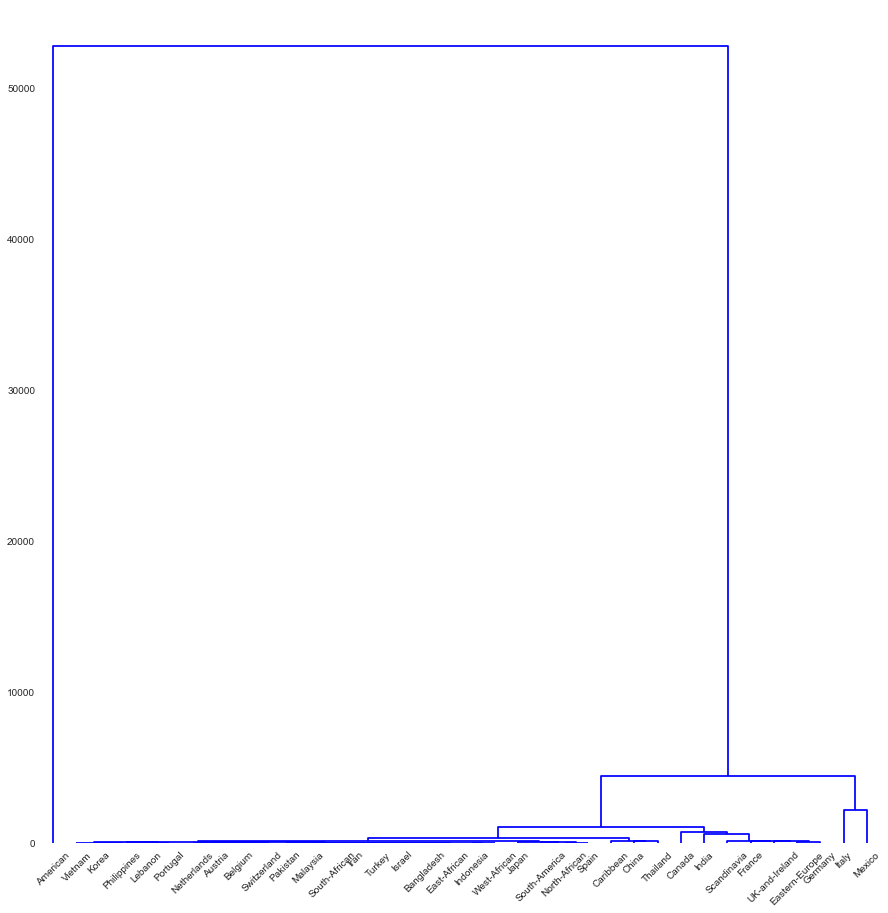

In [15]:
#Functions taken from Lecture 9 

#Calculates the distance matrix 
distanceMatrix = pdist(ingredients_df,'euclidean')

#Calculates Z, I decided to use "ward" to calculate distances since 
# its less susceptible to noise outliers 
Z = hr.linkage(ingredients_df, method='ward', metric='euclidean')

fig = plt.figure(figsize=(15,15))
T = hr.dendrogram(Z,color_threshold=0.5, leaf_font_size=10, labels=ingredients_df.index)
fig.show()

From the above dendogram, we can see that American recipes consists of the outer most 
cluster. This is as expected as the data seemed to consist mostly of American recipes, hence 
skew in the dendogram. This could also be due to American recipes consisting of a variety of other 
cultures. 

While some of the clusters are expected (such as European countries being clustered together and Asian cultures being clustered together, etc) there are also some interesting clusters such as Carribean recipes and recipes from China clustering together. Another interesting clustering is recipes from Japan and South America. This clustering may be due the to a large amount of Japanese immigrants in South America, which may contribute to the similarity in ingredients.

In order to see the clusters better, I removed American recipes from the original data frame to see if anything would change. 

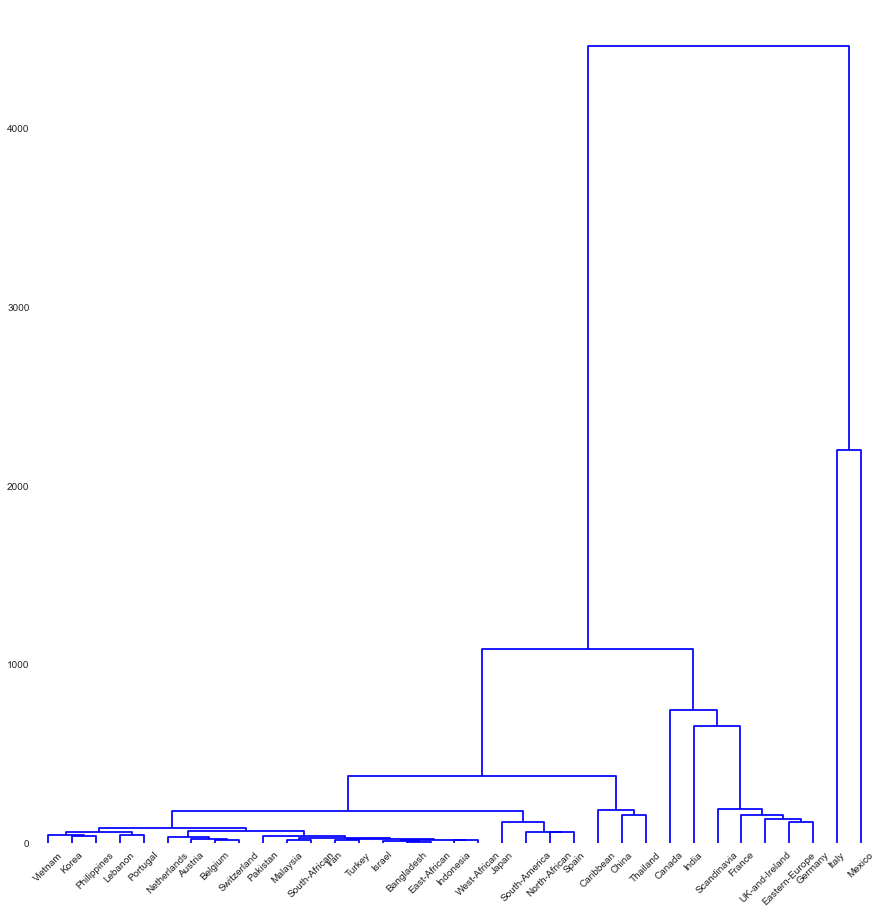

In [18]:
#Drops American recipes from the data frame 
drop_american = ingredients_df.drop('American')

#Calculates the distance matrix 
distanceMatrix1 = pdist(drop_american,'euclidean')

#Calculates Z, I decided to use "ward" to calculate distances since 
# its less susceptible to noise outliers 
Z1 = hr.linkage(drop_american, method='ward', metric='euclidean')

fig1 = plt.figure(figsize=(15,15))
T1 = hr.dendrogram(Z1,color_threshold=0.5, leaf_font_size=10, labels=drop_american.index)
fig1.show()


In the dendogram without American recipes, the clusters are more easily visible. However, the clusters are still relatively the same. The only difference being Mexican recipes being the outer most cluster as opposed to American recipes. 

In [50]:
#Rotates the original dataframes to take a closer look at the number of ingredients per country

rotate = ingredients_df.transpose()

print "Number of American Ingredients: ", rotate.American.sum()
print "Number of Mexican Ingredients: ", rotate.Mexico.sum()
print "Number of Italian Ingredients: ", rotate.Italy.sum()
print "Number of Caribbean Ingredients: ", rotate.Caribbean.sum()
print "Number of Chinese Ingredients: ", rotate.China.sum()



Number of American Ingredients:  274958.0
Number of Mexican Ingredients:  16857.0
Number of Italian Ingredients:  13582.0
Number of Caribbean Ingredients:  1684.0
Number of Chinese Ingredients:  1200.0


From above, we can see that the the number of ingredients for American, Mexican, and Italian are the most abundant in the text file data. This is most likely why American was orignally the outer most cluster, then Mexico, etc. 

I also isolated Caribbean recipes and Chinese recipes to get a better understanding of how they were clustered together. 


In [54]:
print "Chinese Ingredients" 
print rotate.China
print "***"
print
print "Carribbean Ingredients" 
print rotate.Caribbean


Chinese Ingredients
almond          8
angelica        0
anise           0
anise_seed      0
apple           2
apple_brandy    0
apricot         2
artichoke       0
asparagus       2
avocado         0
bacon           2
baked_potato    0
balm            0
banana          0
barley          0
...
wasabi                      0
watercress                  1
watermelon                  0
wheat                      28
wheat_bread                 0
whiskey                     0
white_bread                 0
white_wine                  3
whole_grain_wheat_flour     0
wine                       13
wood                        0
yam                         0
yeast                       4
yogurt                      0
zucchini                    0
Name: China, Length: 346, dtype: float64
***

Carribbean Ingredients
almond           3
angelica         0
anise            2
anise_seed       0
apple            2
apple_brandy     0
apricot          0
artichoke        0
asparagus        0
avocado         

From taking a closer look at the ingredients in Caribbean and Chinese recipes, the clustering is logical due to the similarities in ingredients used. I was a bit surprised since I didn't think Caribbean and Chinese recipes had much in common!

Though, as observed earlier, the clustering could also be due to the number of recipes present in the data we were given. Perhaps if the data were not so skewed, the clusters would differ. 

 References

1. Ahn, Yong-Yeol, et al. "Flavor network and the principles of food pairing." Scientific reports 1 (2011).

In [16]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()

Collaborative Partner: Colleen Gilmore